In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
# from PCMM.PCMMnumpy import kummer_log
from scipy.special import gammaln
import h5py as h5
import pandas as pd
import seaborn as sns
from scipy.signal import hilbert

In [2]:
def draw_sphere(ax,num_lines=20):

    # draw sphere
    u, v = np.mgrid[0:2*np.pi:2*num_lines*1j, 0:np.pi:num_lines*1j]
    # u, v = np.mgrid[0:2*np.pi:40j, 0:np.pi:20j]
    x = np.cos(u)*np.sin(v)
    y = np.sin(u)*np.sin(v)
    z = np.cos(v)

    ax.plot_wireframe(x, y, z, color="k", alpha=0.1, zorder=3)
    # remove ticks
    ax.set_xticks([-1,1])
    ax.set_yticks([-1,1])
    ax.set_zticks([-1,1])
    ax.set_aspect('equal')
    
    # remove axes
    ax.set_axis_off()

    # keep the three main axes but remove the gray area in the middle of the 3d plot
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.grid(False)
    
    return ax

def add_points_to_sphere(ax,P, labels=None):
    num_points = P.shape[1] 
    # plot every second as red and every other second as green
    if labels is not None:
        for k in range(labels.max()+1):
            ax.scatter(P[0,labels==k], P[1,labels==k], P[2,labels==k], color=sns.color_palette("brg", labels.max()+1)[k], s=1, alpha=0.5,zorder=1)
    else:
        # plot every second as red and every other second as green
        ax.scatter(P[0,:num_points//2], P[1,:num_points//2], P[2,:num_points//2], color='r', s=1, alpha=0.5,zorder=1)
        ax.scatter(P[0,num_points//2:], P[1,num_points//2:], P[2,num_points//2:], color='g', s=1, alpha=0.5,zorder=1)
        if P.shape[1]<3:
            ax.plot([0, P[0,0]], [0, P[1,0]], [0, P[2,0]], color='r')
            ax.plot([0, P[0,1]], [0, P[1,1]], [0, P[2,1]], color='g')

    return ax

def get_cmaps():
    # Initialize a dictionary to store the colormaps
    cmaps = []
    # cmaps[1]: White to Pink
    cmaps.append(np.column_stack([np.linspace(1, 0, 256), np.linspace(1, 0.5, 256), np.linspace(1, 0.5, 256)]))
    # cmaps[2]: White to Purple
    cmaps.append(np.column_stack([np.linspace(1, 0.5, 256), np.linspace(1, 0, 256), np.linspace(1, 0.5, 256)]))
    # cmaps[3]: White to Blue
    cmaps.append(np.column_stack([np.linspace(1, 0, 256), np.linspace(1, 0, 256), np.linspace(1, 1, 256)]))
    # cmaps[4]: White to Cyan
    cmaps.append(np.column_stack([np.linspace(1, 0, 256), np.linspace(1, 1, 256), np.linspace(1, 1, 256)]))
    # cmaps[5]: White to Magenta
    cmaps.append(np.column_stack([np.linspace(1, 1, 256), np.linspace(1, 0, 256), np.linspace(1, 1, 256)]))
    # cmaps[6]: White to Yellow
    cmaps.append(np.column_stack([np.linspace(1, 1, 256), np.linspace(1, 1, 256), np.linspace(1, 0, 256)]))
    # cmaps[7]: White to Orange
    cmaps.append(np.column_stack([np.linspace(1, 1, 256), np.linspace(1, 0.5, 256), np.linspace(1, 0, 256)]))
    # cmaps[8]: White to Navy
    cmaps.append(np.column_stack([np.linspace(1, 0, 256), np.linspace(1, 0, 256), np.linspace(1, 0.5, 256)]))
    # cmaps[9]: White to Teal
    cmaps.append(np.column_stack([np.linspace(1, 0, 256), np.linspace(1, 0.5, 256), np.linspace(1, 0.5, 256)]))
    # cmaps[10]: White to Violet
    cmaps.append(np.column_stack([np.linspace(1, 0.5, 256), np.linspace(1, 0, 256), np.linspace(1, 1, 256)]))
    return cmaps

def add_contour_to_sphere(ax,params,num_grid_points=1000,model='watson',threshold=0.95,az=None,el=None):
    K = params['pi'].shape[0]
    # get faces
    theta, phi = np.linspace(0, np.pi, num_grid_points), np.linspace(0, 2 * np.pi, 2*num_grid_points)
    theta, phi = np.meshgrid(theta, phi)
    r = 1  # radius of the sphere

    # Sphere coordinates
    X = r * np.sin(theta) * np.cos(phi)
    Y = r * np.sin(theta) * np.sin(phi)
    Z = r * np.cos(theta)
    # Create the vertices for all faces using slicing and reshaping
    X_faces = np.array([X[:-1, :-1], X[1:, :-1], X[1:, 1:], X[:-1, 1:]]).transpose(1, 2, 0).reshape(-1, 4, 3)
    Y_faces = np.array([Y[:-1, :-1], Y[1:, :-1], Y[1:, 1:], Y[:-1, 1:]]).transpose(1, 2, 0).reshape(-1, 4, 3)
    Z_faces = np.array([Z[:-1, :-1], Z[1:, :-1], Z[1:, 1:], Z[:-1, 1:]]).transpose(1, 2, 0).reshape(-1, 4, 3)

    # Stack X, Y, Z to create the full vertex list (Nx4x3 array)
    verts = np.stack((X_faces, Y_faces, Z_faces), axis=-1).reshape(-1, 4, 3)
    vert_midpoint = np.mean(verts, axis=1)

    if az is not None:
        R_az = np.array([[np.cos(az),-np.sin(az),0],[np.sin(az),np.cos(az),0],[0,0,1]])
        R_el = np.array([[1,0,0],[0,np.cos(el),-np.sin(el)],[0,np.sin(el),np.cos(el)]])
        vert_location = R_az @ R_el @ vert_midpoint.T
        #binarize
        vert_location = (vert_location[0]>0).astype(bool)

    # vert_midpoint = np.array(vert_midpoint)
    num_faces = len(verts)
    
    #calculate colors
    c = np.zeros((num_faces,K))
    for k in range(K):
        if model=='watson':
            M2 = kummer_log(params['kappa'][k],0.5,1.5)
            Cp = gammaln(1.5)-np.log(2)-1.5*np.log(np.pi)-M2

            c[:,k] = np.log(params['pi'][k]) + Cp + params['kappa'][k]*((params['mu'][:,k] @ vert_midpoint.T)**2)

            # for i in range(num_faces):
            #     c[i,k] = np.log(params['pi'][k]) + Cp + params['kappa'][k]*((params['mu'][:,k] @ vert_midpoint[i])**2)
        elif model=='ACG':
            Cp = gammaln(1.5)-np.log(2)-1.5*np.log(np.pi)
            logdeta = np.log(np.linalg.det(params['L'][k]))
            L_inv = np.linalg.inv(params['L'][k])

            for i in range(num_faces):
                B = vert_midpoint[i] @ L_inv @ vert_midpoint[i]
                c[i,k] = np.log(params['pi'][k]) + Cp-0.5*logdeta-1.5*np.log(B)
        else:
            raise ValueError('Model not implemented')
        
    # normalize to values between 0 and 1
    for k in range(K):
        c[:,k] = (c[:,k] - c[:,k].min()) / (c[:,k].max() - c[:,k].min())
    # print(np.min(c),np.max(c[c<1]))

    # set values below threshold to 0
    c_show = np.zeros(c.shape,dtype=bool)
    for k in range(K):  
        c_show[:,k] = c[:,k] > threshold
        # print(c_show[:,k].sum())
        c[c_show[:,k],k] = (c[c_show[:,k],k] - c[c_show[:,k],k].min()) / (c[c_show[:,k],k].max() - c[c_show[:,k],k].min())

    #create K color maps
    cmaps = get_cmaps()
    # norm = plt.Normalize(c.min(), c.max())
    colors = np.zeros((K,num_faces,4))
    for k in range(K):
        colors[k,c_show[:,k],:3] = cmaps[k][(c[c_show[:,k],k]*255).astype(np.uint8)]
        colors[k,c_show[:,k],-1] = 1.0
    
        # Plot the collection of faces
        for foreground in [True,False]:
            if foreground:
                poly = Poly3DCollection(verts[~vert_location], facecolors=colors[k][~vert_location], edgecolor='k', linewidths=0,zorder=2)
            else:
                poly = Poly3DCollection(verts[vert_location], facecolors=colors[k][vert_location], edgecolor='k', linewidths=0,zorder=4)
            ax.add_collection3d(poly)
    return ax


Observations shifted between clusters: 21, convergence towards tol: 4.84e-04:   1%|          | 7/1000 [00:00<00:01, 568.37it/s]

Observations shifted between clusters: 3, convergence towards tol: 7.43e-06:   2%|▎         | 25/1000 [00:00<00:01, 578.51it/s] 


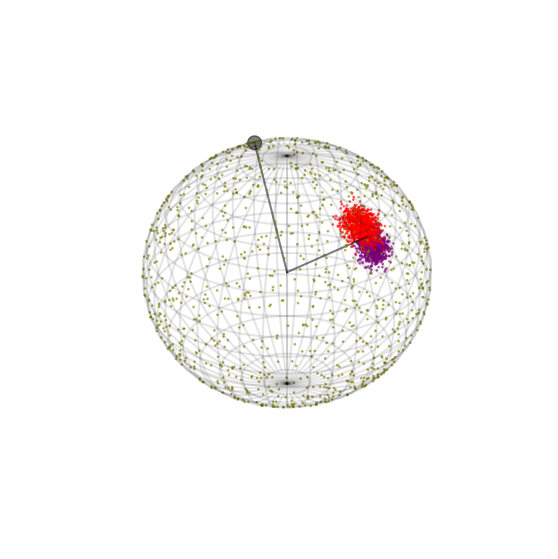

In [3]:
# sample data from a 3d isotropic multivariate normal distribution
noise = 0.01
differentiation_factor = 0.3
n = 1000
data1 = np.random.multivariate_normal([1,1,1], noise*np.eye(3), size=n)
data2 = np.random.multivariate_normal([1-differentiation_factor,1-differentiation_factor,1], noise*np.eye(3), size=n)
background_data = np.random.multivariate_normal([0,0,0], noise*np.eye(3), size=n)

data = np.concatenate((data1, data2,background_data), axis=0)
data /= np.linalg.norm(data, axis=1)[:, np.newaxis]

labels = np.concatenate((np.zeros(n,dtype=int), np.ones(n,dtype=int), 2*np.ones(n,dtype=int)), axis=0)

from PCMM.phase_coherence_kmeans import diametrical_clustering
C,part,obj = diametrical_clustering(data, K=2, max_iter=1000)

# just points
fig, ax = plt.subplots(1, 1, subplot_kw={'projection':'3d'}, figsize=(7,7))
ax = draw_sphere(ax)

ax = add_points_to_sphere(ax,data.T, labels=labels)

#plot the centroids
ax.scatter(C[:,0], C[:,1], C[:,2], color='black', s=100, alpha=0.5)

#plot lines from the origin to the centroids
for i in range(C.shape[0]):
    ax.plot([0, C[i,0]], [0, C[i,1]], [0, C[i,2]], color='black', alpha=0.5,zorder=5)
ax.view_init(30, 0)

# ax.text2D(0.5, 0.8, r'$\operatorname{Re}(e^{i\theta_j(t)})$', transform=ax.transAxes, fontsize=12, ha='center')
# fig.savefig('figures/cluster_results_points_sphere.png',dpi=300,bbox_inches='tight')

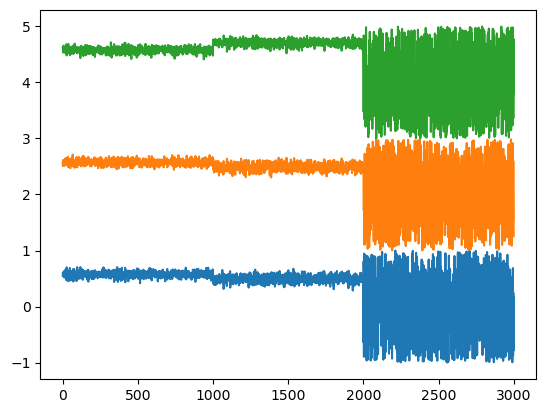

In [4]:
plt.plot(data + np.array([0,2,4]).reshape(1,3))

In [5]:
plt.plot(gs)

NameError: name 'gs' is not defined

Observations shifted between clusters: 2, convergence towards tol: 9.25e-07:   6%|▌         | 55/1000 [00:00<00:01, 477.86it/s] 


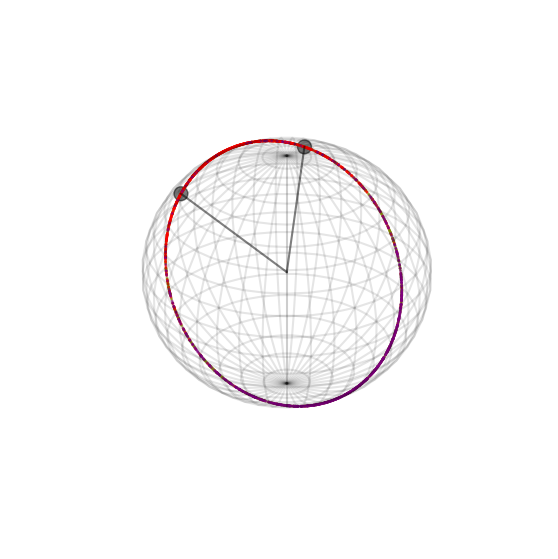

In [ ]:
data_gsr = np.concatenate((data1, data2,background_data), axis=0)
# remove the global signal by regression
gs = np.mean(data_gsr, axis=1)
for i in range(data.shape[1]):
    data_gsr[:,i] = data_gsr[:,i] - gs@data_gsr[:,i]/(gs@gs) * gs


data_gsr /= np.linalg.norm(data_gsr, axis=1)[:, np.newaxis]

labels = np.concatenate((np.zeros(n,dtype=int), np.ones(n,dtype=int), 2*np.ones(n,dtype=int)), axis=0)

from PCMM.phase_coherence_kmeans import diametrical_clustering
C,part,obj = diametrical_clustering(data_gsr, K=2, max_iter=1000)

# just points
fig, ax = plt.subplots(1, 1, subplot_kw={'projection':'3d'}, figsize=(7,7))
ax = draw_sphere(ax)

ax = add_points_to_sphere(ax,data_gsr.T, labels=labels)

#plot the centroids
ax.scatter(C[:,0], C[:,1], C[:,2], color='black', s=100, alpha=0.5)

#plot lines from the origin to the centroids
for i in range(C.shape[0]):
    ax.plot([0, C[i,0]], [0, C[i,1]], [0, C[i,2]], color='black', alpha=0.5,zorder=5)
ax.view_init(30, 0)

# ax.text2D(0.5, 0.8, r'$\operatorname{Re}(e^{i\theta_j(t)})$', transform=ax.transAxes, fontsize=12, ha='center')
# fig.savefig('figures/cluster_results_points_sphere.png',dpi=300,bbox_inches='tight')